In [1]:
import gym
import time
import wandb
import math
import winsound
import random
import json

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy
from stable_baselines import PPO2, A2C, ACKTR, DDPG, SAC, TD3, TRPO

from stable_baselines.ddpg.policies import MlpPolicy as ddpg_MlpPolicy, LnMlpPolicy as ddpg_LnMlpPolicy
from stable_baselines.sac.policies import MlpPolicy as sac_MlpPolicy, LnMlpPolicy as sac_LnMlpPolicy
from stable_baselines.td3.policies import MlpPolicy as td3_MlpPolicy, LnMlpPolicy as td3_LnMlpPolicy

from stable_baselines.common import make_vec_env
from stable_baselines.common.vec_env import DummyVecEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Set paths
root_dir = Path.cwd()

# Training and Evaluation Functions

In [6]:
def train_model(env_kwargs, model_save_path, model_config_save_path, total_timesteps=200000, wandb_logger=None,
                model_load_path=None, model_config_load_path=None, env_name='static_maritime:static-maritime-v0'
               ):
    if model_load_path:
        with open(model_config_load_path) as f:
            env_kwargs = json.load(f)
        
        env = DummyVecEnv([lambda: gym.make(env_name, env_kwargs=env_kwargs)])
        model = PPO2.load(model_load_path, env)
        print("model loaded")
    else:
        env = DummyVecEnv([lambda: gym.make(env_name, env_kwargs=env_kwargs)])
        model = PPO2(MlpPolicy, env, verbose=0, wandb_logger=wandb_logger)
        print("model created")
        
    model.learn(total_timesteps=total_timesteps)
    print('Model has finished learning')
    env.close()

    model.save(model_save_path)
    print("Model successfully saved")

    with open(model_config_save_path, 'w') as fp:
        json.dump(env_kwargs, fp)

    duration = 1000  # milliseconds
    freq = 440  # Hz
    winsound.Beep(freq, duration)
    
    return

In [8]:
def eval_model(model_save_path, model_config_save_path, episodes=50, eval_wandb_project='test',
               env_name='static_maritime:static-maritime-v0', max_timesteps=999
              ):
    with open(model_config_save_path) as f:
        config = json.load(f)
        
    env = DummyVecEnv([lambda: gym.make(env_name, env_kwargs=config)])
    
    model = PPO2.load(model_save_path, env)
    
    if eval_wandb_project:
        eval_wandb = wandb.init(project=eval_wandb_project, config=config)
    
    # Evaluate for n episodes
    # Track cumulative reward
    cumulative_reward = 0
    
    # How far the car was from the goal at each point. Smaller magnitude is better
    total_position_difference = 0
    goal_position = 0.45
    for episode in range(episodes):
        print(f'episode: {episode}')
        obs = env.reset()
        episode_reward = 0
        
        # The action count indicates the timestep
        episode_action_count = 0
        closest_position = -10
        while True:
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            
            if obs[0][0] > closest_position:
                closest_position = obs[0][0]
            episode_action_count += 1
            episode_reward += rewards[0]

            if eval_wandb_project:
                # Timestep logs
                eval_wandb.log({"x_coordinate": obs[0][0]})
                eval_wandb.log({"y_coordinate": obs[0][1]})
                eval_wandb.log({"heading": obs[0][2]})
                eval_wandb.log({"heading_delta": action[0][0]})
                eval_wandb.log({"goal_distance": info[0]["goal_distance"]})
                
            if done[0]:
                print(f'episode action count: {episode_action_count}')
                if episode_action_count == max_timesteps:
                    print(f'Agent failed episode through timeout')
                    
                else:
                    print(f'Agent completed episode under the timestep limit')
                    
                total_position_difference += abs(goal_position - closest_position)
                    
                break
                
        cumulative_reward += episode_reward

        if eval_wandb_project:
            # Episode logs
            eval_wandb.log({"episode": episode, "episode_reward": episode_reward, "cumulative_reward": cumulative_reward})

    # eval_wandb.finish()
    print('evaluation complete')
    avg_position_difference = total_position_difference / episodes
    
    return avg_position_difference, cumulative_reward

## Standard Training

In [ ]:
config = {"action_space": [-math.pi/18, math.pi/18],
          "observation_space": ["x", "y", "heading_delta"],
          "heading_delta_reward_coefficient": 5,
          "goal_distance_reward_coefficient": 5,
          "avoidance_reward": 50,
          "game_over_penalty": 50000,
          "success_reward": 50000,
          "policy": "MlpPolicy",
          "discount_factor": 0.99,
          "learning_rate": 0.00025,
          "entropy_coefficient": 0.01,
          "value_function_coefficient": 0.5,
          "n_env": 1,
          "model": "PPO2",
          "n_obstacles": 10,
          "velocity": 5,
          "save_path": "./PPO2_10_further_examination/convergence_2",
          "timesteps": 1000000
         }


wandb_logger = wandb.init(project='ppo2_10_further_examination_train', config=config)

train_model(config, "./PPO2_10_further_examination/convergence_2",
            "./PPO2_10_further_examination/convergence_2.json",
            wandb_logger=wandb_logger, total_timesteps=1000000
           )
wandb_logger.finish()

## Reward Tuning (Randomised Search)

In [4]:
heading_change_coefs = [0.1, 0.5, 1, 5, 10]

goal_distance_coefs = [0.01, 0.05, 0.1, 0.5, 1]

avoidance_rewards = [0.1, 0.5, 1, 5, 10]

game_over_penalties = [100, 500, 1000, 5000, 10000]

mission_success_rewards = [100, 500, 1000, 5000, 10000]

In [ ]:
# Try 100 different parameters
for i in range(0, 100):
    heading_change_coef = random.sample(heading_change_coefs, 1)[0]
    goal_distance_coef = random.sample(goal_distance_coefs, 1)[0]
    avoidance_reward = random.sample(avoidance_rewards, 1)[0]
    game_over_penalty = random.sample(game_over_penalties, 1)[0]
    mission_success_reward = random.sample(mission_success_rewards, 1)[0]

    # Train with PPO
    config = {"action_space": [-math.pi/18, math.pi/18],
              "observation_space": ["x", "y", "heading_delta"],
              "heading_delta_reward_coefficient": heading_change_coef,
              "goal_distance_reward_coefficient": goal_distance_coef,
              "avoidance_reward": avoidance_reward,
              "game_over_penalty": game_over_penalty,
              "success_reward": mission_success_reward,
              "policy": "MlpPolicy",
              "discount_factor": 0.99,
              "learning_rate": 0.00025,
              "entropy_coefficient": 0.01,
              "value_function_coefficient": 0.5,
              "n_env": 1,
              "model": "PPO2",
             }
    
    train_model(config, f"./PPO2_tuning_10_obstacles/{i}", f"./PPO2_tuning_10_obstacles/model_{i}.json")

# PPO2 Evaluation

## Model Evaluation

Batch Evaluation

In [ ]:
for i in range(0, 55):
    eval_model(f"./PPO2_tuning_10_obstacles/{i}", f"./PPO2_tuning_10_obstacles/model_{i}.json", eval_wandb_project='PPO2_tuning_10_obstacles_eval')

# EA Classic Control

In [4]:
EA_dir = root_dir.joinpath("EA_classic_control")
reward_type_dir = EA_dir.joinpath("original_rewards_actions")

In [7]:
# Train a base population
population_save_path = "./EA_classic_control/original_rewards_distance_10000000_timesteps/population.json"

# If there is no data in the population json
population = {}
# Load the population data from the json if there is
# with open(population_save_path) as f:
#     population = json.load(f)

timesteps = 10000000

for i in range(0, 100):
    print(f'model {i}')
    config = {'completion_reward_coef': 100,
              'action_reward_coef': 0.1
             }
    model_save_path = f"./EA_classic_control/original_rewards_distance_10000000_timesteps/model_{i}"
    model_config_save_path = f"./EA_classic_control/original_rewards_distance_10000000_timesteps/model_{i}_config.json"

    train_model(config, model_save_path, model_config_save_path,
                total_timesteps=timesteps, env_name='MountainCarContinuous-v0'
               )
    fitness_result, cumulative_reward = eval_model(model_save_path, model_config_save_path, episodes=10, eval_wandb_project=None,
                                env_name='MountainCarContinuous-v0'
                               )
    
    population[model_save_path] = {'config': config,
                                   'fitness': fitness_result,
                                   'timesteps': timesteps
                                  }
    
    with open(population_save_path, 'w') as fp:
        json.dump(population, fp)

model 0




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



model created


KeyboardInterrupt: 

In [9]:
# EA
max_iterations = 10000
population_size = 521
training_timesteps = 100000

# Load the population
population_save_path = f'./EA_classic_control/EA_rewards_distance/population.json'
with open(population_save_path) as f:
    population = json.load(f)

for i in range(max_iterations):
    # Tournament Selection
    model1, model2 = random.sample(population.items(), 2)
    model1_fitness = model1[1]['fitness']
    model2_fitness = model2[1]['fitness']
    
    # Compare fitness
    # For the continuous mountain car env, lower time is greater fitness
    if model1_fitness > model2_fitness:
        winner_model = model2
        
    else:
        winner_model = model1
        
    print(f'winning model from tournament selection: {winner_model}')
        
    # Evolve the winning sample
    winner_rewards = winner_model[1]['config']
    evolved_model_rewards = {}
    for key, value in winner_rewards.items():
        # Evolve the reward using a gaussian distribution where the current reward is the mean
        # A quarter of the current reward is the std
        evolved_model_rewards[key] = np.random.normal(value, value/4, 1)[0]
        
    print(f'evolved_model rewards: {evolved_model_rewards}')
        
    # Train the evolved model
    evolved_model_path = f'./EA_classic_control/EA_rewards_distance/model_{population_size + i}'
    evolved_model_config_path = f'./EA_classic_control/EA_rewards_distance/model_{population_size + i}.json'
    
    train_model(winner_rewards, evolved_model_path, evolved_model_config_path,
                total_timesteps=training_timesteps, env_name='MountainCarContinuous-v0'
               )
    
    # Evaluate evolved model's fitness
    fitness_result, reward = eval_model(evolved_model_path, evolved_model_config_path, episodes=10, eval_wandb_project=None,
                                        env_name='MountainCarContinuous-v0'
                                       )
    
    # Add the evolved model and its details into the population
    population[evolved_model_path] = {'config': evolved_model_rewards,
                                      'fitness': fitness_result,
                                      'timesteps': training_timesteps
                                     }
    
    # Delete the worst individual in the population
    weakest_model_path = ''
    weakest_model_fitness = -math.inf
    for model_path, model_details in population.items():
        if model_details['fitness'] > weakest_model_fitness:
            weakest_model_fitness = model_details['fitness']
            weakest_model_path = model_path
            
    print(f'weakest model: {weakest_model_path}')
            
    del population[weakest_model_path]
    
    with open(population_save_path, 'w') as fp:
        json.dump(population, fp)

winning model from tournament selection: ('./EA_classic_control/original_rewards_distance/model_61', {'config': {'completion_reward_coef': 100, 'action_reward_coef': 0.1}, 'fitness': 0.9074695318937301, 'timesteps': 100000})
evolved_model rewards: {'completion_reward_coef': 141.9803548682828, 'action_reward_coef': 0.09253926029376391}
model created
Model has finished learning
Model successfully saved
episode: 0
episode action count: 999
Agent failed episode through timeout
episode: 1
episode action count: 999
Agent failed episode through timeout
episode: 2
episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed episode through timeout
episode: 6
episode action count: 999
Agent failed episode through timeout
episode: 7
episode action count: 999
Agent failed episode through timeout
epis

episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed episode through timeout
episode: 6
episode action count: 999
Agent failed episode through timeout
episode: 7
episode action count: 999
Agent failed episode through timeout
episode: 8
episode action count: 999
Agent failed episode through timeout
episode: 9
episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_527
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_513', {'config': {'completion_reward_coef': 332.2838333194628, 'action_reward_coef': 0.02318008266461428}, 'fitness': 0.9209483832120895, 'timesteps': 100000})
evolved_model rewards: {'completion_reward_coef': 435.66775165463116, 'action_reward_coef': 0.02017564644893217}
model created
Model has finished learning
Model successfully saved
episode: 0
episode action count: 999
Agent failed e

model created
Model has finished learning
Model successfully saved
episode: 0
episode action count: 999
Agent failed episode through timeout
episode: 1
episode action count: 999
Agent failed episode through timeout
episode: 2
episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed episode through timeout
episode: 6
episode action count: 999
Agent failed episode through timeout
episode: 7
episode action count: 999
Agent failed episode through timeout
episode: 8
episode action count: 999
Agent failed episode through timeout
episode: 9
episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_534
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_213', {'config': 

episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_417
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_284', {'config': {'completion_reward_coef': 135.9455088875181, 'action_reward_coef': 0.03879630572557692}, 'fitness': 0.9174787312746048, 'timesteps': 100000})
evolved_model rewards: {'completion_reward_coef': 117.82103653028089, 'action_reward_coef': 0.04395302369705272}
model created
Model has finished learning
Model successfully saved
episode: 0
episode action count: 999
Agent failed episode through timeout
episode: 1
episode action count: 999
Agent failed episode through timeout
episode: 2
episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed e

episode action count: 999
Agent failed episode through timeout
episode: 2
episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed episode through timeout
episode: 6
episode action count: 999
Agent failed episode through timeout
episode: 7
episode action count: 999
Agent failed episode through timeout
episode: 8
episode action count: 999
Agent failed episode through timeout
episode: 9
episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_547
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_420', {'config': {'completion_reward_coef': 97.38269293345263, 'action_reward_coef': 0.09250757049404106}, 'fitness': 0.9009832322597504, 'timesteps': 100000})
evolved_m

model created
Model has finished learning
Model successfully saved
episode: 0
episode action count: 999
Agent failed episode through timeout
episode: 1
episode action count: 999
Agent failed episode through timeout
episode: 2
episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed episode through timeout
episode: 6
episode action count: 999
Agent failed episode through timeout
episode: 7
episode action count: 999
Agent failed episode through timeout
episode: 8
episode action count: 999
Agent failed episode through timeout
episode: 9
episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_554
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_519', {'config': 

episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_560
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_430', {'config': {'completion_reward_coef': 74.98686695963502, 'action_reward_coef': 0.11007613851725989}, 'fitness': 0.9227598279714584, 'timesteps': 100000})
evolved_model rewards: {'completion_reward_coef': 32.50321779331636, 'action_reward_coef': 0.13196040132356399}
model created
Model has finished learning
Model successfully saved
episode: 0
episode action count: 999
Agent failed episode through timeout
episode: 1
episode action count: 999
Agent failed episode through timeout
episode: 2
episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed ep

episode action count: 999
Agent failed episode through timeout
episode: 3
episode action count: 999
Agent failed episode through timeout
episode: 4
episode action count: 999
Agent failed episode through timeout
episode: 5
episode action count: 999
Agent failed episode through timeout
episode: 6
episode action count: 999
Agent failed episode through timeout
episode: 7
episode action count: 999
Agent failed episode through timeout
episode: 8
episode action count: 999
Agent failed episode through timeout
episode: 9
episode action count: 999
Agent failed episode through timeout
evaluation complete
weakest model: ./EA_classic_control/EA_rewards_distance/model_567
winning model from tournament selection: ('./EA_classic_control/EA_rewards_distance/model_405', {'config': {'completion_reward_coef': 93.33273629987178, 'action_reward_coef': 0.08529060311051986}, 'fitness': 0.9301902711391449, 'timesteps': 100000})
evolved_model rewards: {'completion_reward_coef': 72.75327553032388, 'action_reward

KeyboardInterrupt: 

In [9]:
def evaluate_population(population_save_path):
    # Load the population
    with open(population_save_path) as f:
        population = json.load(f)

    best_fitness = math.inf
    best_model = 'NIL'
    fitness_values = []
    for model_path, model_details in population.items():
        fitness_values.append(model_details['fitness'])
        if model_details['fitness'] < best_fitness:
            best_model = model_path
            best_fitness = model_details['fitness']

    plt.hist(fitness_values, bins=100)
    plt.title("Distribution of population fitness")
    plt.show()
    
    return best_model, best_fitness, fitness_values

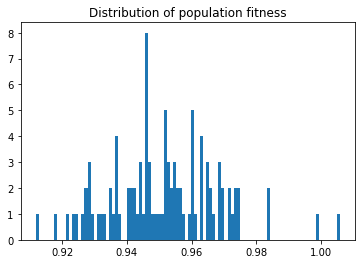

In [10]:
best_model, best_fitness, no_rewards_fitness = evaluate_population("./EA_classic_control/no_rewards_distance/population.json")

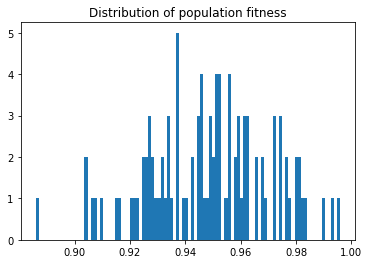

In [48]:
best_model, best_fitness, original_rewards_fitness = evaluate_population("./EA_classic_control/original_rewards_distance/population.json")

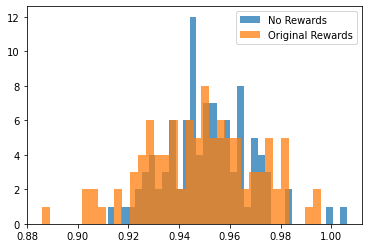

In [58]:
bins = 35
plt.hist(no_rewards_fitness, bins, alpha=0.75, label='No Rewards')
plt.hist(original_rewards_fitness, bins, alpha=0.75, label='Original Rewards')
plt.legend(loc='upper right')
plt.show()